In [16]:
# Import standard libraries
import base64
import json
import os
os.environ['USE_PYGEOS'] = '0'
import yaml

# Import installed libraries
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from odc.stac import stac_load, configure_rio
import pandas as pd
from pyproj.crs import CRS
from pystac_client import Client
import seaborn as sns
from shapely.geometry import Point, Polygon
import xarray as xr

# Import local modules
import sys
project_path = os.path.abspath(os.path.join('..'))
if project_path not in sys.path:
    sys.path.append(project_path)
from library import utils
from library.FH_Hydrosat import FH_Hydrosat, FH_StackedDataset

# Read configuration file
with open("../config.yml","r") as f:
    config = yaml.safe_load(f)

In [17]:
# Specify crop type
met_tower = 'corn'

# Set start and end dates for assessment
start_date = "2022-04-01T00:00:00Z"
end_date = "2022-08-31T00:00:00Z"

# Define paths to data
data_dir = os.path.join('..', 'data', 'Ameriflux')
file_name = config[met_tower]['data_params']['file_name']
file_path = os.path.join(data_dir, file_name)

# Filter meteorological data by dates
filt = (
    (met_df.index > start_date) & (met_df.index < end_date)
)
met_df = met_df.loc[filt]

In [18]:
# Authenticate and access catalog
with open(os.path.join('..', 'secrets', 'creds.json')) as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

In [19]:
# Create geometries for selected agricultural field
geom = {'type': 'Point', 'coordinates': config[met_tower]['field_center']}
met_tower_pt = Point(config[met_tower]['metpoint'])
pt = Point(geom['coordinates'])
poly = Polygon(config[met_tower]['aoi_coordinates'])
poly_gdf = gpd.GeoDataFrame({'geometry':[poly]}, crs=CRS.from_epsg(4326))
poly_gdf = poly_gdf.to_crs(crs = CRS.from_epsg(32610))
poly_gdf_buffer = poly_gdf.buffer(1000)
aoi = pt

In [20]:
# Connect to Sentinel 2 composite collection
collection = 'prepped_inputs_s2'
asset = 'surface_reflectance'
s2_comp_items = utils.connect_to_collection(catalog, aoi, collection, 
                                start_date, end_date)
# Read items in Sentinel 2 collection in the assessment area
s2_comp_clip = utils.read_and_clip_items(s2_comp_items, asset, poly_gdf_buffer)

In [21]:
# Connect to MODIS composite collection
collection = 'prepped_inputs_mcd43a4'
asset = 'surface_reflectance'
# modis_rgb_bands = [0,3,2]
# modis_nir_band = 1

modis_comp_items = utils.connect_to_collection(catalog, aoi, collection, 
                                    start_date, end_date)
# Read items in MODIS collection in the assessment area
modis_comp_clip = utils.read_and_clip_items(modis_comp_items, asset, 
                                            poly_gdf_buffer)

In [22]:
# Connect to Fused Land Surface Temperature collection
collection = 'starfm_predictions_modis_landsat'
asset = 'lst'

lst_items = utils.connect_to_collection(catalog, aoi, collection, 
                                  start_date, end_date)
# Read items in MODIS collection in the assessment area
lst_clip = utils.read_and_clip_items(lst_items, asset, poly_gdf_buffer, 
                                     dims=("y", "x"))

In [23]:
# Define NDVI function
def calc_ndvi(ds, red_band, nir_band):
    red = ds.sel(band=red_band)
    nir = ds.sel(band=nir_band)
    ndvi = (nir - red) / (nir + red)
    return ndvi

In [24]:
# Create NDVI from Sentinel-2 composite data
s2c_ndvi = calc_ndvi(s2_comp_clip, red_band=2, nir_band=6)
s2c_ndvi = s2c_ndvi.rio.set_crs(CRS.from_epsg(32610))

In [25]:
# Clip NDVI from imagery to field boundary
s2c_ndvi_field = s2c_ndvi.rio.clip(poly_gdf.geometry, all_touched=True, drop=True)

In [26]:
# Filter meteorological data by dates
filt = ( 
    (met_df.index > start_date) 
    & (met_df.index < end_date)
)
df_year = met_df.loc[filt]

In [27]:
# Extract time series of max daily temperature 
ta = df_year['TA'].groupby(df_year.index.date).max()
ta.index = pd.to_datetime(ta.index)

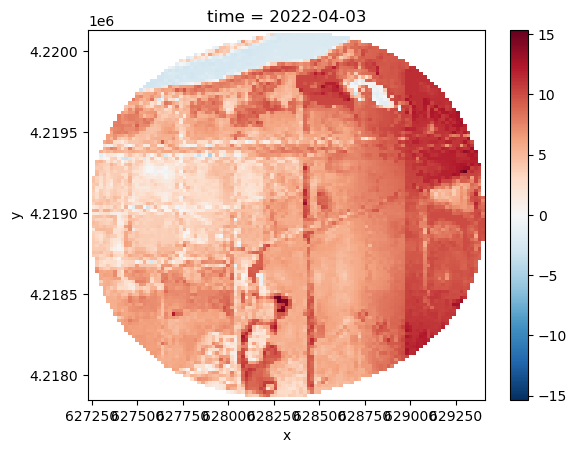

In [28]:
# Calculate CATD for each date
catd_list = []

for date in lst_clip['time']:
    date_indexer = pd.to_datetime(date.values)
    if date_indexer in ta.index:
        temp = ta.loc[date_indexer]
        temp_K = temp + 273.15
        catd_ds = lst_clip.sel(time=date) - temp_K
        catd_list.append(catd_ds)

catd_clip = xr.concat(catd_list, dim='time')
catd_clip = catd_clip.rio.set_crs(CRS.from_epsg(32610))
catd_clip[0].plot.imshow()


In [29]:
# Clip NDVI from imagery to field boundary
catd_field = catd_clip.rio.clip(poly_gdf.geometry, all_touched=True, drop=True)

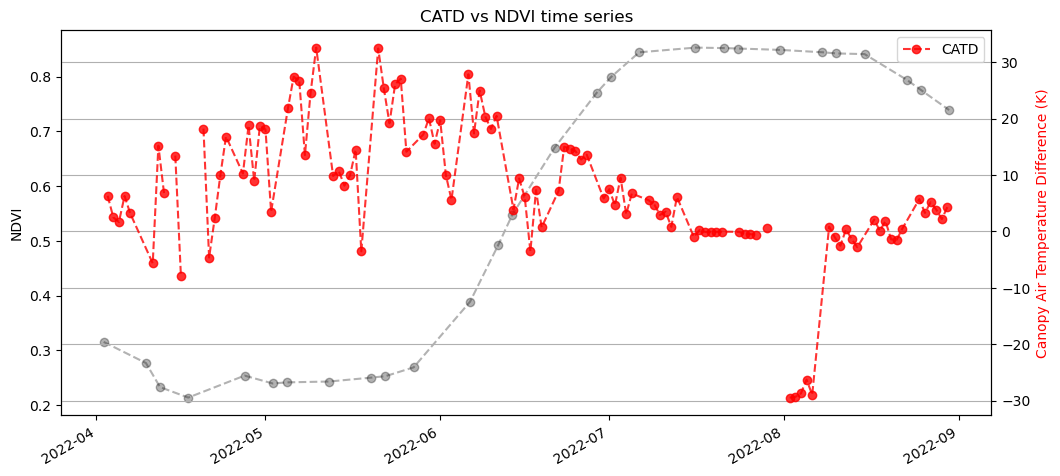

In [30]:
# Plot all NDVI series
fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

catd_field.mean(dim=('x', 'y')).plot(ax=ax2, linestyle='--', alpha=0.8, marker='o', c='r', label='CATD')
# met_ndvi.groupby(met_ndvi.index.date).max().plot(ax=ax, linestyle='--', alpha=0.3, marker='o', c='k', label='Max Daily Tower NDVI')
s2c_ndvi_field.mean(dim=('x', 'y')).plot(ax=ax, linestyle='--', alpha=0.3, marker='o', c='k', label='Sentinel-2 Composite NDVI')

ax2.set_title("CATD vs NDVI time series")
ax2.set_xlabel("")
ax2.set_ylabel("Canopy Air Temperature Difference (K)", color='r')

ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("NDVI")

plt.grid(True)
plt.legend()
plt.show()